# Convolutional autoencoders

In this script we write a CNN autoencoder and apply it to the task of image desnoising.

In [62]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import copy

# Define the data repository
data_dir = 'data/'

In [63]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

# Plot function
def myplot(x):
    plt.figure()
    plt.imshow(x.detach().squeeze().numpy(), cmap='gray')
    plt.show()
    return

## Transposed convolution

As seen in the previous lab, convolution usually reduces the size of the image (except if we compensate using padding). However, in some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. That's notably needed for autoencoders, since after projecting the data into a compact latent representation, we need to expand this representation back into the image space.

This is exactly what [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)


On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transpoed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

torch.Size([1, 1, 343, 550])


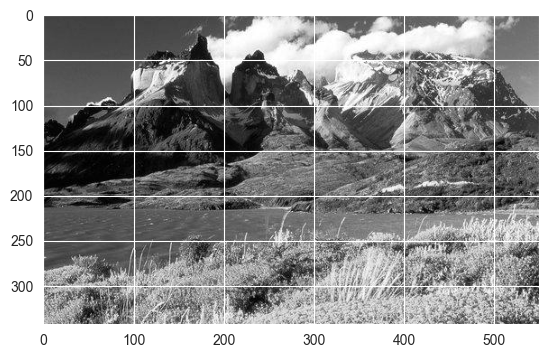

In [64]:
# Load the provided example image as black and white, and normalize it so the values range in [0, 1]
image_np = io.imread('tdp.jpeg', as_gray=True)
image_np = image_np / np.max(image_np)

# Convert it to a Pytorch tensor, and expand to a batch
image_t = torch.tensor(image_np).float()
image_t = image_t.unsqueeze(0).unsqueeze(0)

# Print the shape and plot it
print(image_t.shape)
myplot(image_t)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])


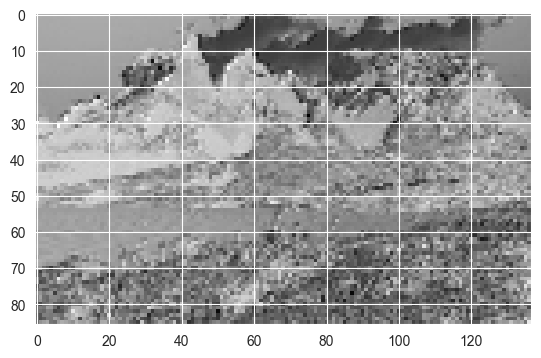

In [65]:
num_channels_in = 1
num_channels_out = 1

# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# Display the output after convolution
myplot(output)

After applying transposed convolution :  torch.Size([1, 1, 343, 550])


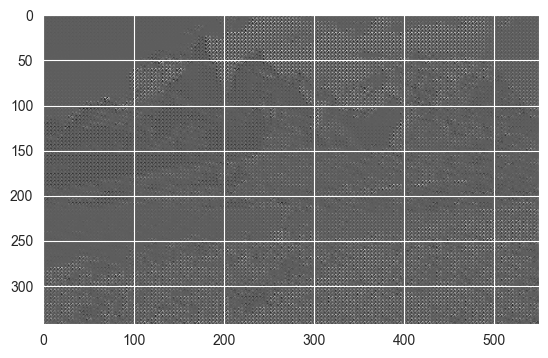

In [66]:
# Now we reproduce an image with the same size as the original input
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

# Display the output after transposed convolution
myplot(image_convt)

As you can see, transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

## Dataset

In [67]:
# Load the MNIST dataset
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## CNN autoencoder

As seen in lab 4, autoencoders are networks that project the input data into a low-dimension space, and then expand this compact representation back into the input space. In CNN autoencoders, the encoder uses convolutions to reduce the image size, while the decoder uses transposed convolutions to expand it. We propose the following architecture:

- The encoder consists of two layers, with a convolution function, a RELU and a max pooling. The convolution functions have a kernel size of 3 and a padding of 1. They use 16 and 4 output channels, respectively. The max pooling functions use a kernel size of 2.

- The decoder consists of two layers, with a transposed convolution and an activation function (RELU for the first layer, Sigmoid for the second layer). The transposed convolution functions have a kernel size of 2 and a stride of 2. They use 16 and 1 output channels, respectively.

In [68]:
# TO DO: write the CNN autoencoder module ('__init__' and 'forward' methods)
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)

        return out

class CNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU())

        self.cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid())

    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)

        return out

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Create instances of MLPClassif_Decoder and MLPClassif_Encoder
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()

    def forward(self, x):
        y = self.encoder(x)
        out = self.decoder(y)
        return out

In [69]:
# Instantiate the CNN autoencoder, initialize it and print the number of parameters
model_cnn_ae = CNNAutoencoder()
torch.manual_seed(0)
model_cnn_ae.apply(init_weights)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_ae.parameters()))

Total number of parameters: 1077


In [70]:
# Before training, make sure that the output of the autoencoder has the same shape as its input.
# If that's not the case, there's something to debug somewhere.
image_batch_example = next(iter(train_dataloader))[0]
out = model_cnn_ae(image_batch_example)
print(image_batch_example.shape)
print(out.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


In [71]:
# TO DO: write the training function.
# It's similar to the MLP autoencoder (lab 4 - uses the ADAM optimizer), but images don't need to be vectorized
def train_cnn_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()

    # define the optimizer (ADAM)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # Initialize a list to save the training loss over epochs
    loss_all_epochs = []

    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0

        # Iterate over batches (here we don't need labels
        for batch, (images, _) in enumerate(train_dataloader):

            # forward pass
            images_predicted = model_tr(images)
            loss = loss_fn(images_predicted, images)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            loss_current_epoch += loss.item()

        loss_current_epoch /= len(train_dataloader)
        # At the end of each epoch, record the loss over all batches
        loss_all_epochs.append(loss_current_epoch)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

    return model_tr, loss_all_epochs

In [72]:
# TO DO:
# - define the trainig/optimizer parameters: 50 epochs, MSE loss function, learning_rate=0.001
# - train the model
loss_fn = nn.MSELoss()
num_epochs = 50
learning_rate = 0.001
model_cnn_ae_tr, train_losses = train_cnn_ae(model_cnn_ae, train_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.1182
Epoch [2/50], Training loss: 0.7883
Epoch [3/50], Training loss: 0.6067
Epoch [4/50], Training loss: 0.5593
Epoch [5/50], Training loss: 0.5370
Epoch [6/50], Training loss: 0.5270
Epoch [7/50], Training loss: 0.5211
Epoch [8/50], Training loss: 0.5173
Epoch [9/50], Training loss: 0.5146
Epoch [10/50], Training loss: 0.5125
Epoch [11/50], Training loss: 0.5110
Epoch [12/50], Training loss: 0.5097
Epoch [13/50], Training loss: 0.5088
Epoch [14/50], Training loss: 0.5078
Epoch [15/50], Training loss: 0.5071
Epoch [16/50], Training loss: 0.5065
Epoch [17/50], Training loss: 0.5060
Epoch [18/50], Training loss: 0.5054
Epoch [19/50], Training loss: 0.5048
Epoch [20/50], Training loss: 0.5045
Epoch [21/50], Training loss: 0.5040
Epoch [22/50], Training loss: 0.5036
Epoch [23/50], Training loss: 0.5032
Epoch [24/50], Training loss: 0.5029
Epoch [25/50], Training loss: 0.5026
Epoch [26/50], Training loss: 0.5023
Epoch [27/50], Training loss: 0.5020
Epoch [28/

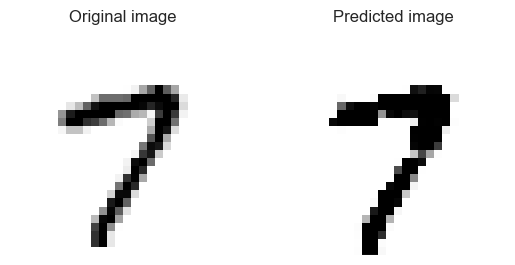

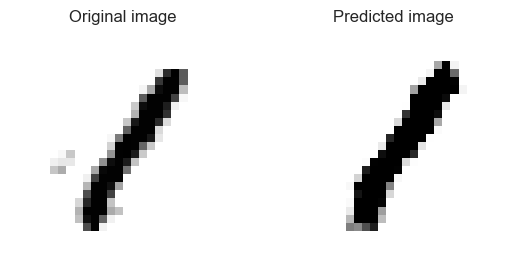

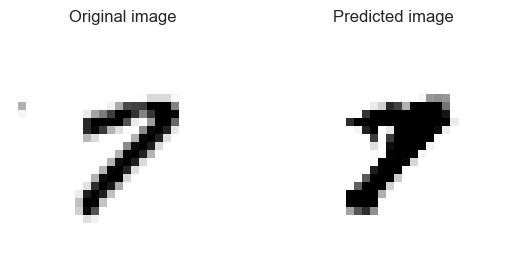

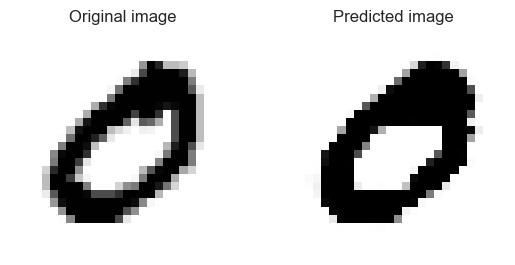

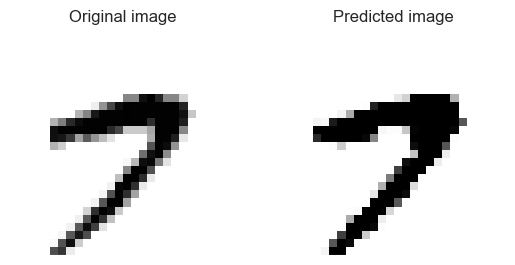

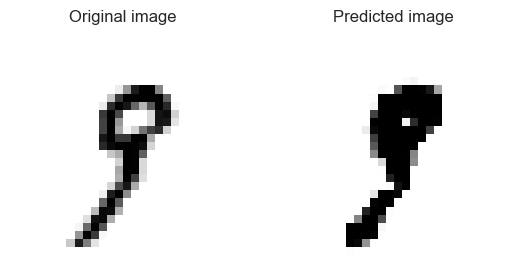

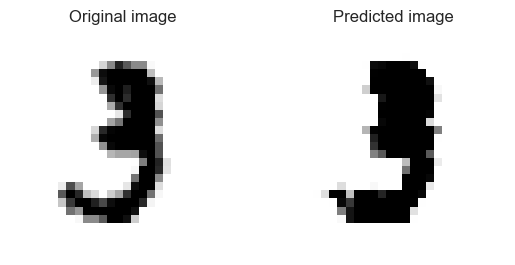

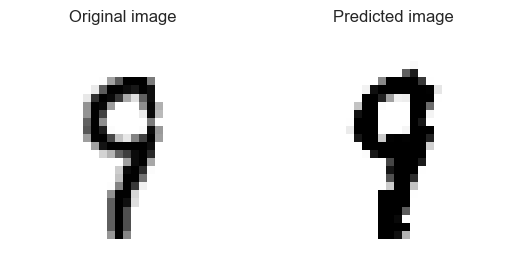

In [73]:
# Vizualization: apply the autoencoder to a batch of images

# Load it
image_batch_example = next(iter(train_dataloader))[0]

# Pass it to the autoencoder 
predicted_batch_example = model_cnn_ae_tr(image_batch_example).detach()

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q3**</span> Put one of the plots above in your report.

## Denoising autoencoder

We now consider an application of autoencoders, which is image denoising. For this task, we can use the same CNN autoencoder model as before: the only thing that changes is the data on which it is trained.

<center><a href="https://en.wikipedia.org/wiki/Total_variation_denoising">
    <img src="https://upload.wikimedia.org/wikipedia/en/e/e8/ROF_Denoising_Example.png"></a></center>


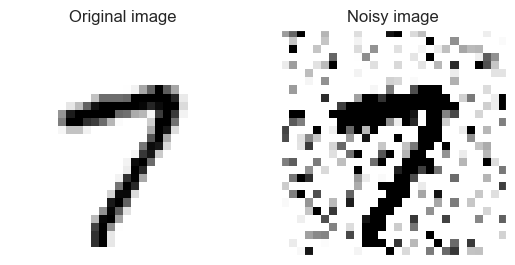

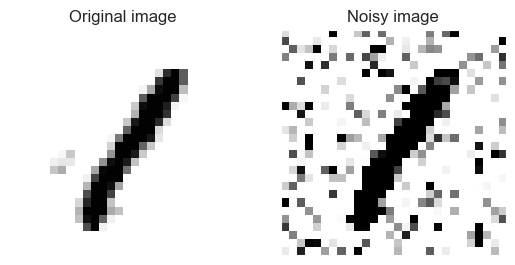

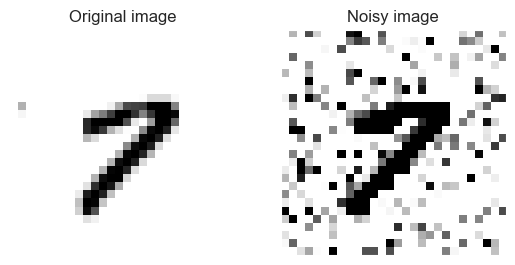

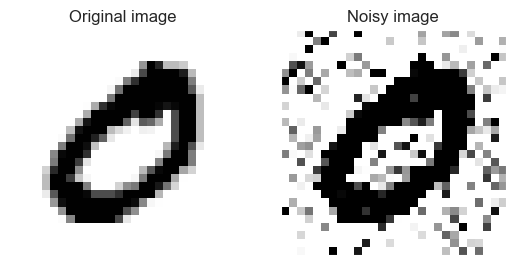

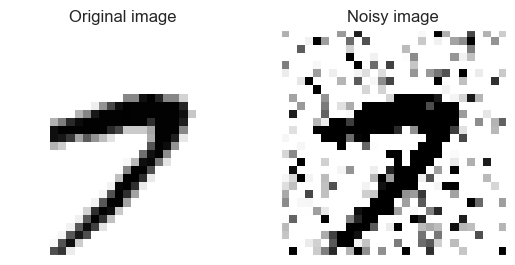

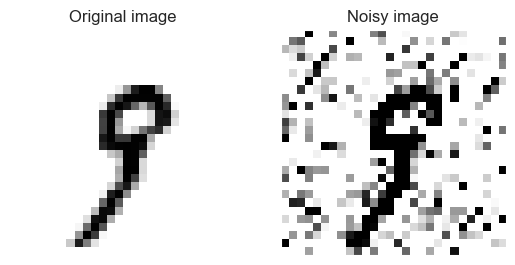

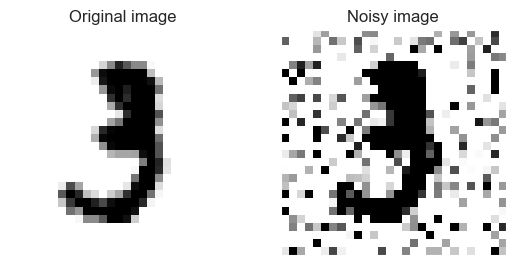

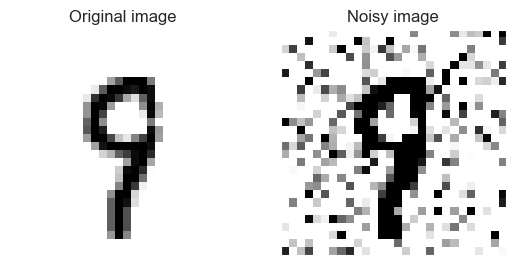

In [74]:
# First, here is a function that adds some noise to an input image batch
def add_noise(inputs,noise_factor=0.8):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

# Add noise to the image_batch_example
noisy_images_batch = add_noise(image_batch_example)

# Plot the original and noisy images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.show()

Since we don't want to create a new dataset, we will simply add noise to the images during training. Therefore, the training function should be the same as before, except we add noise to the images between passing them to the model. Then, we compute the loss between the (true) clean images and the output of the model.

In [78]:
# TO DO: write the training function for the denoising autoencoder
def train_cnn_den_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()

    # define the optimizer (ADAM)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # Initialize a list to save the training loss over epochs
    loss_all_epochs = []

    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0

        # Iterate over batches (here we don't need labels
        for batch, (images, _) in enumerate(train_dataloader):

            # forward pass
            images_noise = add_noise(images)
            images_predicted = model_tr(images_noise)
            loss = loss_fn(images_predicted, images)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            loss_current_epoch += loss.item()

        loss_current_epoch /= len(train_dataloader)
        # At the end of each epoch, record the loss over all batches
        loss_all_epochs.append(loss_current_epoch)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

    return model_tr, loss_all_epochs

In [79]:
# TO DO:
# - instantiate CNN autoencoder and initialize its parameters
# - define the training parameters: 50 epochs, MSE loss function, learning_rate=0.001
# - train the model
loss_fn = nn.MSELoss()
num_epochs = 50
learning_rate = 0.001
model_cnn_dens_ae_tr, train_losses = train_cnn_den_ae(model_cnn_ae, train_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.1347
Epoch [2/50], Training loss: 1.0050
Epoch [3/50], Training loss: 0.9317
Epoch [4/50], Training loss: 0.8551
Epoch [5/50], Training loss: 0.7412
Epoch [6/50], Training loss: 0.6624
Epoch [7/50], Training loss: 0.6467
Epoch [8/50], Training loss: 0.6343
Epoch [9/50], Training loss: 0.6142
Epoch [10/50], Training loss: 0.5974
Epoch [11/50], Training loss: 0.5858
Epoch [12/50], Training loss: 0.5757
Epoch [13/50], Training loss: 0.5646
Epoch [14/50], Training loss: 0.5544
Epoch [15/50], Training loss: 0.5464
Epoch [16/50], Training loss: 0.5410
Epoch [17/50], Training loss: 0.5381
Epoch [18/50], Training loss: 0.5349
Epoch [19/50], Training loss: 0.5329
Epoch [20/50], Training loss: 0.5304
Epoch [21/50], Training loss: 0.5286
Epoch [22/50], Training loss: 0.5263
Epoch [23/50], Training loss: 0.5255
Epoch [24/50], Training loss: 0.5243
Epoch [25/50], Training loss: 0.5239
Epoch [26/50], Training loss: 0.5228
Epoch [27/50], Training loss: 0.5212
Epoch [28/

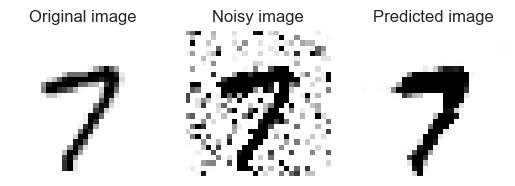

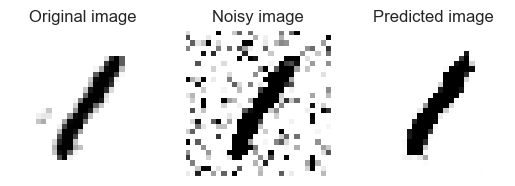

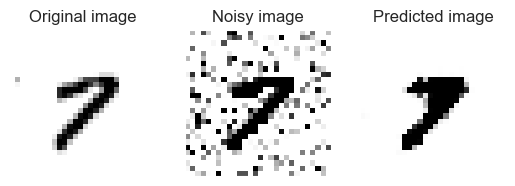

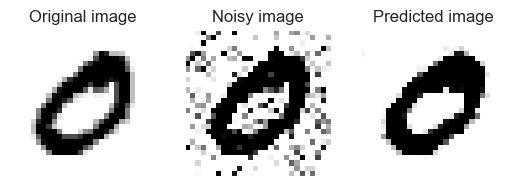

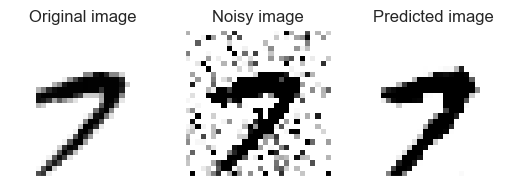

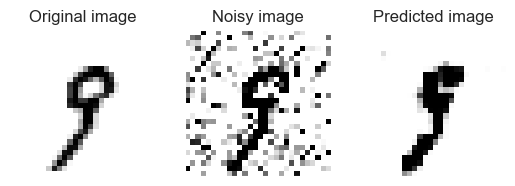

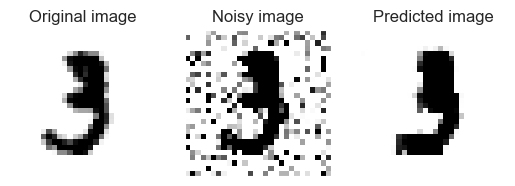

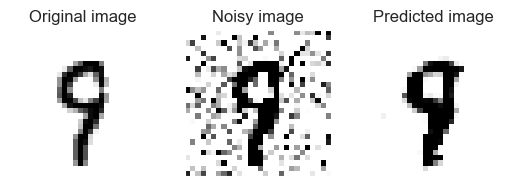

In [80]:
# Vizualization: apply the denoising autoencoder to a batch of noisy images

# Pass it to the autoencoder 
predicted_batch_example = model_cnn_dens_ae_tr(noisy_images_batch).detach()

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q4**</span> Put one of the plots above in your report.

In [87]:
x1 = torch.randn(10, 12, 4, 8)
x2 = torch.randn(10, 5, 4, 8)
y = torch.cat((x1, x2), dim=17)
y
# x1.shape()
# z = torch.stack(???, dim=?)

IndexError: Dimension out of range (expected to be in range of [-4, 3], but got 17)